In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as SF
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import sys as System
import pyspark.sql.types as Types
spark = SparkSession.builder.getOrCreate()
import time as Time

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/21 04:26:45 INFO SparkEnv: Registering MapOutputTracker
23/12/21 04:26:45 INFO SparkEnv: Registering BlockManagerMaster
23/12/21 04:26:45 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/21 04:26:46 INFO SparkEnv: Registering OutputCommitCoordinator


In [2]:
# Data Acquisition code used to acquire data which did not scale well hence moved to using big query

# import requests, zipfile, io
# time1 = DateTime.datetime(2023,1,1)
# time2 = DateTime.datetime(2023,10,5)
# time_change = DateTime.timedelta(days=1)
# while(time1.date()<=time2.date()):
#     gkg_df = master_df.filter((sf.col('_C2').rlike(str(time1.date()).replace('-','')))&(sf.col('_C2').rlike('gkg'))).select(sf.col('_C2'))
#     event_df = master_df.filter((sf.col('_C2').rlike(str(time1.date()).replace('-','')))&(sf.col('_C2').rlike('export'))).select(sf.col('_C2'))
#     mention_df = master_df.filter((sf.col('_C2').rlike(str(time1.date()).replace('-','')))&(sf.col('_C2').rlike('mentions'))).select(sf.col('_C2'))
    
#     for link in gkg_df.collect():
#         try:
#             r = requests.get(link['_C2'])
#             z = zipfile.ZipFile(io.BytesIO(r.content))
#             z.extractall("./zip_files/gkg")
#         except Exception:
#             print('This link has failed',link['_C2'])

#     for link in event_df.collect():
#         try:
#             r = requests.get(link['_C2'])
#             z = zipfile.ZipFile(io.BytesIO(r.content))
#             z.extractall("./zip_files/events")
#         except Exception:
#             print('This link has failed',link['_C2'])
#     for link in mention_df.collect():
#         try:
#             r = requests.get(link['_C2'])
#             z = zipfile.ZipFile(io.BytesIO(r.content))
#             z.extractall("./zip_files/mentions")
#         except Exception:
#             print('This link has failed',link['_C2'])
#     print('Dates Processed',time1.date())
#     time1 = time1+time_change

In [3]:
#Dropping columns 
#Confidence - All news articles are interpreted with 100% confidence
#DocumentIdentifier - just to view article
#Reads 23.5M records
gdelt_df = spark.read.csv('gs://spark-gdelt-analysis/data-25',header=True).drop("Confidence").drop("DocumentIdentifier").drop("FractionDate").drop("IsRootEvent").drop("MentionDocTone")

In [4]:
gdelt_df.printSchema()

root
 |-- GLOBALEVENTID: string (nullable = true)
 |-- GKGRECORDID: string (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- GoldsteinScale: string (nullable = true)
 |-- AvgTone: string (nullable = true)
 |-- Actor1CharOffset: string (nullable = true)
 |-- Actor2CharOffset: string (nullable = true)
 |-- ActionCharOffset: string (nullable = true)
 |-- V2Themes: string (nullable = true)
 |-- V2Tone: string (nullable = true)
 |-- QuadClass: string (nullable = true)



In [5]:
list_col_name = [col_name for col_name in gdelt_df.columns]

In [6]:
#trimming all columns
for col in list_col_name:
    gdelt_df = gdelt_df.withColumn(col,SF.trim(col))

In [7]:
#Removing duplicate records that have the same GLOBALEVENTID GKGRECORDID
gdelt_df = gdelt_df.dropDuplicates(["GLOBALEVENTID","GKGRECORDID"])

#Dropping records where prediction column QuadClass, V2Tone, V2Themes are null
gdelt_df=gdelt_df.filter(SF.col('QuadClass').isNotNull())
gdelt_df=gdelt_df.filter(SF.col('V2Tone').isNotNull())
gdelt_df=gdelt_df.filter(SF.col('V2Themes').isNotNull())

In [8]:
#Converting the V2Themes to array of "KEY|VALUE" string
gdelt_df=gdelt_df.select(*list_col_name, SF.regexp_replace("V2Themes",",","|").alias("V2Themes1"))
gdelt_df=gdelt_df.select(*list_col_name, SF.split('V2Themes1',';').alias("V2Themes1"))
gdelt_df=gdelt_df.drop("V2Themes")

In [9]:
# UDF that takes in ["KEY|VALUE"] sorts the array according to VALUE and return the best 5 KEY(String) or NA  
def extract_numerical(val:str)->list[str]:
    return int(val.split('|')[1])

def best_themes_func(arr_str):
    arr_str = arr_str[0:len(arr_str)-1]
    for string in arr_str:
        string.strip()
    sorted_list = sorted(arr_str,key=extract_numerical)
    theme_list = [theme.split('|')[0] for theme in sorted_list]
    while(len(theme_list)<=5):
        theme_list.append("NA")
    return theme_list[:5]
extract_top5_themes = SF.udf(lambda input: best_themes_func(input),Types.ArrayType(Types.StringType()))

In [10]:
gdelt_df=gdelt_df.withColumn("V2Themes1",extract_top5_themes(SF.col("V2Themes1")))

In [11]:
# Alternative approach without using UDF that didnt scale well
# v2themes_df = gdelt_df.select('GLOBALEVENTID','GKGRECORDID',
#                      (SF.regexp_replace("V2Themes",","," ")).alias('V2Themes'))
# v2themes_df=v2themes_df.select('GLOBALEVENTID','GKGRECORDID'
#                                  ,SF.split('V2Themes',';').alias('V2Themes'))
# v2themes_df=v2themes_df.select('GLOBALEVENTID','GKGRECORDID',
#                   SF.explode('V2Themes').alias('V2Themes'))
# themes_offset_df = v2themes_df.select(SF.col("GLOBALEVENTID"),SF.col("GKGRECORDID"),(SF.split('V2Themes',' ')[0]).alias("Theme"),(SF.split('V2Themes',' ')[1]).alias('Offset'))
# themes_offset_df = themes_offset_df.filter(SF.col('Theme')!='')
# window_theme =  Window.partitionBy("GLOBALEVENTID","GKGRECORDID").orderBy(SF.col("Offset"))
# themes_offset_df = themes_offset_df.withColumn("row",SF.row_number().over(window_theme)).filter(SF.col("row")<=5).drop('row')
# drop offset and combine the columns grouping the GLOBALEVENTID and GKGRECORDID

In [12]:
#Splitting the array of string to its own column
for index in range(0,5):
    gdelt_df=gdelt_df.withColumn("Theme_"+str(index),SF.col("V2Themes1")[index])
gdelt_df=gdelt_df.drop("V2Themes1")

In [13]:
#Replacing null values in string with "NA"
actor_col_list=["Actor1Code","Actor1CountryCode","Actor2Code","Actor2CountryCode"]
for col_name in actor_col_list:
    gdelt_df=gdelt_df.withColumn(col_name, SF.when(SF.col(col_name).isNotNull(),SF.upper(col_name)).otherwise("NA"))

In [14]:
#Dropping organisation data as the number of organisations have high cardinality (Dropped this column at begining when moving from 3 million to 23 million data)
# print(gdelt_df.withColumn("Organisation",(SF.split(SF.col("V2Organizations"),',')[0])).groupBy("Organisation").count().count())
# print(gdelt_df.count())
# gdelt_df=gdelt_df.drop("V2Organizations")

In [15]:
# Casting the below columns to integer and filling all the Null and NA columns with 0
col_cast_int = ["GoldsteinScale","QuadClass","AvgTone"]
for col_name in col_cast_int:
    gdelt_df=gdelt_df.withColumn(col_name,SF.col(col_name).cast("int"))
gdelt_df=gdelt_df.na.fill(value=0,subset=col_cast_int)

In [16]:
# Identifying the max values of offset for the below columns
col_cast_int = ['Actor1CharOffset','Actor2CharOffset','ActionCharOffset']
# for val in col_cast_int:
#     gdelt_df.select(val).summary().show()


In [17]:
#Replacing null char offset with MaxInteger to denote the offset was never present
for val in col_cast_int:
    gdelt_df=gdelt_df.withColumn(val, SF.when((SF.col(val).cast("int").isNotNull()),SF.col(val).cast("int")).otherwise(999999))

In [18]:
gdelt_df.printSchema()

root
 |-- GLOBALEVENTID: string (nullable = true)
 |-- GKGRECORDID: string (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- GoldsteinScale: integer (nullable = true)
 |-- AvgTone: integer (nullable = true)
 |-- Actor1CharOffset: integer (nullable = true)
 |-- Actor2CharOffset: integer (nullable = true)
 |-- ActionCharOffset: integer (nullable = true)
 |-- V2Tone: string (nullable = true)
 |-- QuadClass: integer (nullable = true)
 |-- Theme_0: string (nullable = true)
 |-- Theme_1: string (nullable = true)
 |-- Theme_2: string (nullable = true)
 |-- Theme_3: string (nullable = true)
 |-- Theme_4: string (nullable = true)



In [19]:
for val in col_cast_int:
    gdelt_df=gdelt_df.withColumn(val, SF.when(SF.col(val)>=0,SF.col(val)).otherwise(999999))

In [20]:
# Splitting the V2Tone col using ',' delimeter and assigning individual columns to it
gdelt_df=gdelt_df.withColumn("ArticleTone",  SF.split(SF.col("V2Tone"),',')[0].cast("int"))
gdelt_df=gdelt_df.withColumn("PositiveScore", SF.split(SF.col("V2Tone"),',')[1].cast("int"))
gdelt_df=gdelt_df.withColumn("NegativeScore", SF.split(SF.col("V2Tone"),',')[2].cast("int"))
gdelt_df=gdelt_df.withColumn("Polarity", SF.split(SF.col("V2Tone"),',')[3].cast("int")).drop("V2Tone")

In [5]:
# Identfying Categorical data from continuous data to pass it to the String Indexer
categorical_col = ["Actor1Code","Actor2Code","Actor1CountryCode","Actor2CountryCode"]
for i in range(0,5):
    categorical_col.append('Theme_'+str(i))
categorical_col_si = [col+'_SI' for col in categorical_col]

In [22]:
# This code does not scale well and throws memory exception for mapping 
# for val in list_col_to_si:
#     temp_df = gdelt_df.select(val).distinct().withColumn(val+"_SI",SF.monotonically_increasing_id())
#     gdelt_df = gdelt_df.join(temp_df,val,how="inner").drop(val)

#Converting the String values of categorical data into integers using a estimator and a transformer
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=categorical_col, outputCols=categorical_col_si,handleInvalid='skip')
string_indexer_transformer = indexer.fit(gdelt_df)
gdelt_df=string_indexer_transformer.transform(gdelt_df)

In [23]:
# Dropping string type of catagorical columns
for col_name in categorical_col:
    gdelt_df=gdelt_df.drop(col_name)

In [7]:
continuous_col=["GoldsteinScale","AvgTone","Actor1CharOffset","Actor2CharOffset","ActionCharOffset","ArticleTone","PositiveScore","NegativeScore","Polarity"]
target = ["QuadClass"]

In [6]:
gdelt_df.printSchema()

root
 |-- GLOBALEVENTID: string (nullable = true)
 |-- GKGRECORDID: string (nullable = true)
 |-- GoldsteinScale: integer (nullable = true)
 |-- AvgTone: integer (nullable = true)
 |-- QuadClass: integer (nullable = true)
 |-- Actor1CharOffset_I: integer (nullable = true)
 |-- Actor2CharOffset_I: integer (nullable = true)
 |-- ActionCharOffset_I: integer (nullable = true)
 |-- ArticleTone: integer (nullable = true)
 |-- PositiveScore: integer (nullable = true)
 |-- NegativeScore: integer (nullable = true)
 |-- Polarity: integer (nullable = true)
 |-- Actor1Code_SI: double (nullable = true)
 |-- Actor2Code_SI: double (nullable = true)
 |-- Actor1CountryCode_SI: double (nullable = true)
 |-- Actor2CountryCode_SI: double (nullable = true)
 |-- Theme_0_SI: double (nullable = true)
 |-- Theme_1_SI: double (nullable = true)
 |-- Theme_2_SI: double (nullable = true)
 |-- Theme_3_SI: double (nullable = true)
 |-- Theme_4_SI: double (nullable = true)



In [26]:
continuous_col

['GoldsteinScale',
 'AvgTone',
 'Actor1CharOffset',
 'Actor2CharOffset',
 'ActionCharOffset',
 'ArticleTone',
 'PositiveScore',
 'NegativeScore',
 'Polarity']

23/12/21 01:01:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/12/21 01:03:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


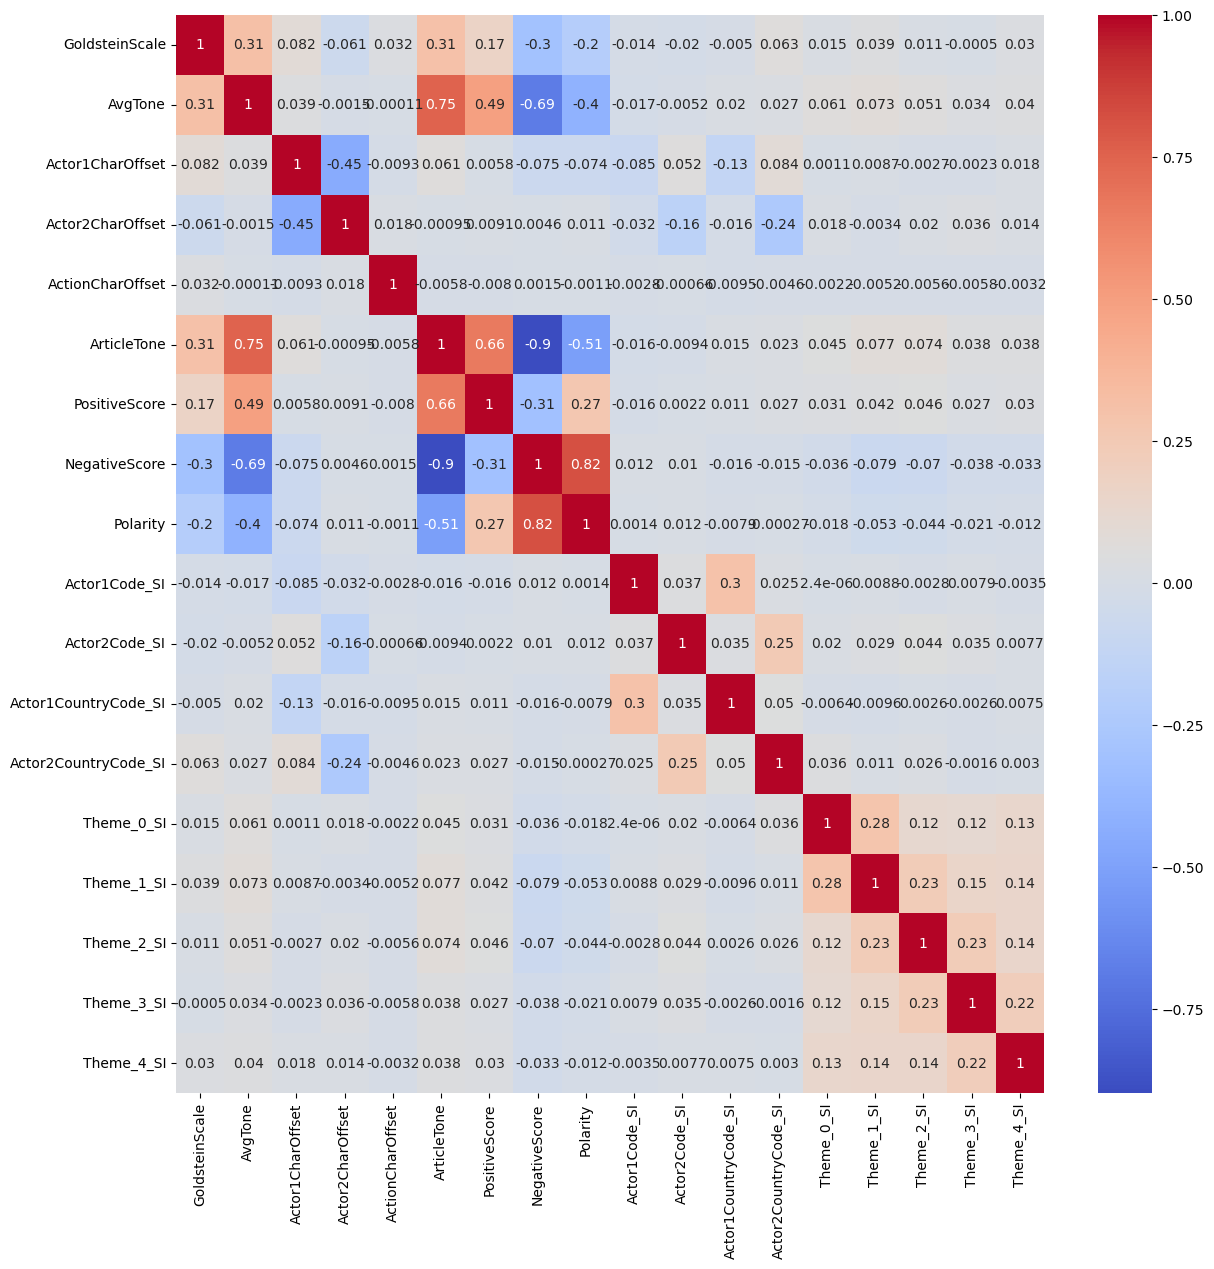

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_col = continuous_col+categorical_col_si
corr_pd = gdelt_df.select(*corr_col).limit(5000).toPandas().corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_pd,annot=True,cmap='coolwarm')
plt.show()

In [27]:
gdelt_df.show(100)

23/12/21 03:08:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/12/21 03:10:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


+-------------+--------------------+--------------+-------+----------------+----------------+----------------+---------+-----------+-------------+-------------+--------+-------------+-------------+--------------------+--------------------+----------+----------+----------+----------+----------+
|GLOBALEVENTID|         GKGRECORDID|GoldsteinScale|AvgTone|Actor1CharOffset|Actor2CharOffset|ActionCharOffset|QuadClass|ArticleTone|PositiveScore|NegativeScore|Polarity|Actor1Code_SI|Actor2Code_SI|Actor1CountryCode_SI|Actor2CountryCode_SI|Theme_0_SI|Theme_1_SI|Theme_2_SI|Theme_3_SI|Theme_4_SI|
+-------------+--------------------+--------------+-------+----------------+----------------+----------------+---------+-----------+-------------+-------------+--------+-------------+-------------+--------------------+--------------------+----------+----------+----------+----------+----------+
|   1052322515| 20220703040000-T214|             1|     -1|          999999|              17|               0|     

In [3]:
#Saving the intermediate results to save some computational time

#gdelt_df.write.mode("overwrite").parquet("gs://spark-gdelt-analysis/gdelt_data_final_25/")
#gdelt_df  = spark.read.parquet("gs://spark-gdelt-analysis/gdelt_data_final_25/",header=True)

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


In [34]:
# Creates a pipeline converting continuous_col feature to vector -> Normalising the data using MinMaxScaler -> combining the cateorial
# and continuous data using vector assembler -> outputting the features to Logistic Regression Model
def get_lr_pipeline():
    continuous_features_assembler = VectorAssembler(inputCols=continuous_col,outputCol="continous_features")
    features_scaler = MinMaxScaler(inputCol="continous_features",outputCol="continuousf_scaled")
    features_assembler = VectorAssembler(inputCols=categorical_col_si+["continuousf_scaled"],outputCol="features")
    lr = LogisticRegression(featuresCol="features", labelCol="QuadClass", predictionCol="prediction")
    gdelt_pipleline = Pipeline(
        stages = [continuous_features_assembler,features_scaler,features_assembler,lr]
    )
    return gdelt_pipleline

23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_70 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_19 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_118 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_29 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_39 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_84 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_107 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_49 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_59 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_109_95 !
23/12/21 04:18:55 WARN BlockManagerMasterEndpoin

In [29]:
train, test = gdelt_df.randomSplit([0.8, 0.2], 13)

In [30]:
# Trains the model using Train Validation Split stratergy evaluating based on f1 metrics for models having 0.2 0.5 elastic net param
evaluator = MulticlassClassificationEvaluator(labelCol="QuadClass",predictionCol="prediction",metricName="f1")
lr = LogisticRegression()
grid_search = (ParamGridBuilder().addGrid(lr.elasticNetParam, [0.2,0.5]).build())
tvs = TrainValidationSplit(estimator=get_lr_pipeline(),
                           estimatorParamMaps=grid_search,
                           evaluator=evaluator,
                           trainRatio=0.8)

In [31]:
tvs_model=tvs.fit(train)

23/12/21 01:11:10 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_160 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_140 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_64 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_55 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_186 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_17 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_26 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_74 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_62_170 !
23/12/21 01:33:28 WARN BlockManagerMasterEndpoint: No more repli

KeyboardInterrupt: 

In [ ]:
tvs_model.validationMetrics

In [9]:
# Creating a pipeline with set elastic net param to compute the metrics and latency for each input size
def get_lr_pipeline_elastic_param():
    continuous_features_assembler = VectorAssembler(inputCols=continuous_col,outputCol="continous_features")
    features_scaler = MinMaxScaler(inputCol="continous_features",outputCol="continuousf_scaled")
    features_assembler = VectorAssembler(inputCols=categorical_col_si+["continuousf_scaled"],outputCol="features")
    lr = LogisticRegression(featuresCol="features", labelCol="QuadClass", predictionCol="prediction",elasticNetParam=0.5)
    gdelt_pipleline = Pipeline(
        stages = [continuous_features_assembler,features_scaler,features_assembler,lr]
    )
    return gdelt_pipleline

In [9]:
# Computes the run time of the logistic regression pipeline for the inputs 15 25 50 75 100
import time as Time
NUM_ROWS = gdelt_df.count()
for input_rows in [15,25,50,75,100]:
    input_size = int((input_rows*NUM_ROWS)/100)
    count =2;
    end=0
    while(count>0):
        print("Input Size ",input_size )
        start=Time.time()
        temp_df = gdelt_df.limit(input_size)
        train_temp,test_temp = temp_df.randomSplit([0.8, 0.2], 13)
        lr_pipline =  get_lr_pipeline_elastic_param().fit(train_temp)
        pred = lr_pipline.transform(test_temp)
        end = end +(Time.time()-start)
        count-=1
    print("Time Taken for Input Size",input_size,end/2)

Input Size  3363200


23/12/16 05:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 05:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 05:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:10:46 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:10:52 WAR

Input Size  3363200


23/12/16 05:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 05:14:26 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 05:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:16:48 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:16:50 WAR

Time Taken for Input Size 3363200 359.1631660461426
Input Size  5605333


23/12/16 05:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:19:53 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 05:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:21:29 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 05:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:23:30 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:23:35 WAR

Input Size  5605333


23/12/16 05:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 05:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 05:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:31:19 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:31:22 WAR

Time Taken for Input Size 5605333 461.3857078552246
Input Size  11210667


23/12/16 05:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 05:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:37:35 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 05:39:01 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:41:09 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:41:17 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:41:42 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:41:51 WAR

Input Size  11210667


23/12/16 05:53:13 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:53:51 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 05:54:50 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:55:46 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 05:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 05:57:55 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:59:44 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 05:59:55 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:00:07 WAR

Time Taken for Input Size 11210667 1130.1640694141388
Input Size  16816001


23/12/16 06:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 06:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 06:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 06:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 06:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1764.0 KiB
23/12/16 06:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:21:19 WARN DAGScheduler: Broadcasting large task binary with size 1765.7 KiB
23/12/16 06:21:28 WAR

Input Size  16816001


23/12/16 06:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 06:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
23/12/16 06:39:22 WARN YarnAllocator: Container from a bad node: container_1702699012756_0001_01_000028 on host: cluster-7d34-w-1.us-east1-b.c.alert-shape-407800.internal. Exit status: 137. Diagnostics: [2023-12-16 06:39:21.816]Container killed on request. Exit code is 137
[2023-12-16 06:39:21.816]Container exited with a non-zero exit code 137. 
[2023-12-16 06:39:21.817]Killed by external signal
.
23/12/16 06:39:22 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 27 for reason Container from a bad node: container_1702699012756_0001_01_000028 on host: cluster-7d34-w-1.us-east1-b.c.alert-shape-407800.internal. Exit status: 137. Diagnostics: [2023-12-16 06:39:21.816]Container killed on request. Exit code is 137
[2023-12-16 06:39:21.816]Container exited with a non-zero exit code

Time Taken for Input Size 16816001 1597.473342180252
Input Size  22421335


23/12/16 07:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1702.3 KiB
23/12/16 07:06:13 WARN DAGScheduler: Broadcasting large task binary with size 1739.1 KiB
23/12/16 07:06:22 WARN YarnAllocator: Container from a bad node: container_1702699012756_0001_01_000030 on host: cluster-7d34-w-1.us-east1-b.c.alert-shape-407800.internal. Exit status: 137. Diagnostics: [2023-12-16 07:06:21.326]Container killed on request. Exit code is 137
[2023-12-16 07:06:21.327]Container exited with a non-zero exit code 137. 
[2023-12-16 07:06:21.328]Killed by external signal
.
23/12/16 07:06:22 ERROR YarnScheduler: Lost executor 29 on cluster-7d34-w-1.us-east1-b.c.alert-shape-407800.internal: Container from a bad node: container_1702699012756_0001_01_000030 on host: cluster-7d34-w-1.us-east1-b.c.alert-shape-407800.internal. Exit status: 137. Diagnostics: [2023-12-16 07:06:21.326]Container killed on request. Exit code is 137
[2023-12-16 07:06:21.327]Container exited with a non-zero exit code

KeyboardInterrupt: 

In [11]:
gdelt_df.groupBy("QuadClass").count().show()

+---------+--------+
|QuadClass|   count|
+---------+--------+
|        1|13947009|
|        3| 2766522|
|        4| 3003870|
|        2| 2703934|
+---------+--------+



In [10]:
# Computes the precision recall accuracy for the entire data set for the best logistic model
train_temp,test_temp = gdelt_df.randomSplit([0.8, 0.2], 13)
lr_pipline =  get_lr_pipeline_elastic_param().fit(train_temp)
pred = lr_pipline.transform(test_temp)
pred.groupby("QuadClass").pivot("prediction").count().show()
metrics = lr_pipline.stages[-1].evaluate(pred.select("QuadClass","features"))
# Precision
print("Precision")
for i, prec in enumerate(metrics.precisionByLabel):
    print("label %d: %s" % (i+1, prec))
# Recall
print("Recall")
for i, prec in enumerate(metrics.recallByLabel):
    print("label %d: %s" % (i+1, prec))
# Accuracy
print("Accuracy")
metrics.accuracy

23/12/21 04:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1740.7 KiB
23/12/21 04:30:02 WARN DAGScheduler: Broadcasting large task binary with size 1725.5 KiB
23/12/21 04:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1768.7 KiB
23/12/21 04:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1769.8 KiB
23/12/21 04:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1770.2 KiB
23/12/21 04:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1771.4 KiB
23/12/21 04:32:41 WARN DAGScheduler: Broadcasting large task binary with size 1770.2 KiB
23/12/21 04:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1771.4 KiB
23/12/21 04:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1770.2 KiB
23/12/21 04:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1771.4 KiB
23/12/21 04:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1770.2 KiB
23/12/21 04:32:48 WAR

+---------+-------+-----+------+------+
|QuadClass|    1.0|  2.0|   3.0|   4.0|
+---------+-------+-----+------+------+
|        1|2746160|36406|  8211|     5|
|        3|   8358|   19|472350| 72826|
|        4|   null| null|126725|474479|
|        2| 335274|87925|117748|  null|
+---------+-------+-----+------+------+

Precision


23/12/21 04:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1778.4 KiB


label 1: 0.8887847466755043
label 2: 0.7070767993566546
label 3: 0.6514866889001067
label 4: 0.8669291626317809
Recall
label 1: 0.9840109331363037
label 2: 0.1625390287773109
label 3: 0.8533058261810522
label 4: 0.7892146426171482
Accuracy


0.842733934754282